In [1]:
%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

pd.options.display.float_format = "{:.3f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

import pickle
from datetime import datetime

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [4]:
def load_results(file_name):
    data = None
    with open(file_name, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        data = pickle.load(f)
    return data

def filter_top_model_results(top_models, all_model_results):
    plot_data = list()
    for idx, row in top_models.iterrows():
        #print("row.label: " + row.label + ',' + row.classifier + ',' + row.sampling_method)
        for res in all_model_results:       
            for alg_results in res:
                if alg_results[0] == row.label and alg_results[1] == row.classifier and alg_results[2] == row.sampling_method:
                    #print(alg_results)
                    label, model_name, sampling_method, _, tpr, fpr, roc_auc, precision, recall, prc_auc = alg_results

                    plot_data.append(("{} :: {}".format(row.classifier_short, sampling_method), tpr, fpr, roc_auc, precision, recall, prc_auc))
    return plot_data

def rebuild_results(res):
    ## Gather all the metrics
    temp_metrics = pd.DataFrame()
    temp_results = list()
    for i in range(0, len(res)):
        temp_metrics = pd.concat([temp_metrics, res[i][1]])
        temp_results.append(res[i][2]) 
    
    return temp_metrics, temp_results

In [5]:
measurements       = ['classifier_short', 'sampling_method', \
                      #'fp', 'fn',\
                      'balanced_accuracy', 'recall', 'precision', \
                      #'f1_score',\
                      'train_time', 'aucroc', 'auprc',\
                      'model_churn_cost']

measurements_alias = ['classifier', 'sampling', \
                      'bal_acc', 'recall', 'precision',\
                      # 'f1',\
                      'train_time', 'auroc', 'auprc',\
                      'churn_cost']

In [6]:
## First Experiment:
## Approach 1.1 - Churn BasicData + Default Hyper

EXP_KEY = 'exp1_1'

exp1_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Basic_DefaultHyper_2019-08-12.pickle')
#exp2_1 = load_results('/home/dissertation/code/RESULTS_FINAL/Manual_GridSearch_2019-08-10.pickle')
#exp2_2 = load_results('/home/dissertation/code/RESULTS_FINAL/Manual_RdmSearch_2019-08-10.pickle')
#exp3_1 = load_results('/home/dissertation/code/RESULTS_FINAL/DFS_Default_2019-08-10.pickle')
#exp3_2 = load_results('/home/dissertation/code/RESULTS_FINAL/DFS_RdmSearch_2019-08-18.pickle')

exp_metrics, exp_results = rebuild_results(exp1_1)

## Summarise performance of the approaches

In [7]:
# Convert train_time
exp_metrics['train_time'] = (exp_metrics['train_time']/60)
exp_metrics['cv_time'] = (exp_metrics['cv_time']/60)

# Convert model_churn_cost to EUR from TWD
exp_metrics['model_churn_cost'] = np.round(exp_metrics['model_churn_cost'] * 0.029).astype(int)

di = {'GaussianNB':'GNB', 'DecisionTreeClassifier':'DT', 'RandomForestClassifier':'RF',
       'LogisticRegression':'LR', 'MLPClassifier':'MLP', 'XGBClassifier':'XGB'}

exp_metrics['classifier_short'] = exp_metrics['classifier'].map(di)

exp_metrics.head()

,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,train_time,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample,classifier_short
0,NB_basic_5cv_recall,GaussianNB,None,218384,11343,12718,15042,0.898,0.458,0.529,...,0.080,0.051,0.819,0.538,0.732,0.530,0.003,244978,0,GNB
0,DT_basic_5cv_recall,DecisionTreeClassifier,None,223281,13139,10922,10145,0.910,0.518,0.454,...,0.170,0.083,0.686,0.437,0.705,0.452,0.006,251610,0,DT
0,RF_basic_5cv_recall,RandomForestClassifier,None,228814,13844,10217,4612,0.928,0.689,0.425,...,0.172,0.124,0.830,0.573,0.702,0.417,0.007,243742,0,RF
0,LR_basic_5cv_recall,LogisticRegression,None,233426,24061,0,0,0.907,0.000,0.000,...,0.078,0.046,0.718,0.452,0.500,-1.000,-1.000,348884,0,LR
0,MLP_basic_5cv_recall,MLPClassifier,None,233426,24061,0,0,0.907,0.000,0.000,...,10.339,12.266,0.500,0.547,0.500,-1.000,-1.000,348884,0,MLP


In [8]:
measure_by = ['balanced_accuracy', 'recall', 'model_churn_cost']
measure_by_sort = [False, False, True]

# measure_by = ['balanced_accuracy']
# measure_by_sort = [False]

# measure_by = ['model_churn_cost']
# measure_by_sort = [True]

# measure_by = ['f1_score']
# measure_by_sort = [False]

### The best/worst 5 performing models as measured by .... 

In [9]:
print("Getting best results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))
top_results = exp_metrics.sort_values(measure_by, ascending=measure_by_sort)
top_results = top_results[measurements].head(5)

### The lowest 5 performing models by approach as measured by .... 
print("Getting worst results for {} / ordered ascending? {}".format(measure_by, [not f for f in measure_by_sort]))
worst_results = exp_metrics.sort_values(measure_by, ascending=[not f for f in measure_by_sort])
worst_results = worst_results[measurements].head(5)

results = pd.concat([top_results, worst_results])
results.columns = measurements_alias
results

#print(temp.to_latex(index=False))

Getting best results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [False, False, True]
Getting worst results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [True, True, False]


,classifier,sampling,bal_acc,recall,precision,train_time,auroc,auprc,churn_cost
0,XGB,ROS 1:1,0.810,0.742,0.384,2.677,0.881,0.624,224834
0,XGB,RUS 1:1,0.808,0.740,0.381,0.248,0.882,0.623,226043
0,XGB,ROS 3:2,0.803,0.709,0.412,2.155,0.881,0.623,221386
0,XGB,SMOTE_NC,0.801,0.713,0.399,2.692,0.873,0.603,224811
0,RF,RUS 1:1,0.797,0.765,0.316,0.049,0.867,0.555,251044
0,LR,None,0.500,0.000,0.000,0.078,0.718,0.452,348884
0,MLP,None,0.500,0.000,0.000,10.339,0.500,0.547,348884
0,MLP,RUS 1:1,0.500,0.000,0.000,6.362,0.500,0.547,348884
0,LR,ROS 3:1,0.500,0.000,0.000,0.084,0.718,0.452,348884
0,MLP,ROS 3:1,0.500,0.000,0.000,23.710,0.500,0.547,348884


### Summary performance statistics of classifiers over all sampling techniques

In [10]:
## Excludes LR and MLP as those produce bad classifiers

stats_summary = {'best':max,
                 'median':'median', 
                 'iqr':lambda x: np.percentile(x, 75, interpolation='higher') - np.percentile(x, 25, interpolation='lower'),
                 #'range':lambda x: max(x) - min(x)
                }
#[~exp_metrics.recall.isin([0.0, 1.0])]
summary = \
    exp_metrics\
            .groupby(['classifier_short'])\
            .agg({
                 'balanced_accuracy':stats_summary,
                 'recall':stats_summary,
                 'precision':stats_summary,
                 'model_churn_cost':{'best':min},
                 #'aucroc':stats_summary,
                 #'auprc':stats_summary,
                 'train_time':'median',
                 })\
            .reset_index()\
            .sort_values(('balanced_accuracy', 'best'), ascending=False)
summary
#print(summary.to_latex(index=False))

/home/anaconda/envs/py373/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


classifier_short balanced_accuracy              recall               \
                                best median   iqr   best median   iqr   
5              XGB             0.810  0.801 0.035  0.742  0.709 0.143   
4               RF             0.797  0.735 0.007  0.765  0.521 0.052   
0               DT             0.772  0.720 0.010  0.740  0.507 0.063   
1              GNB             0.765  0.759 0.009  0.638  0.603 0.029   
2               LR             0.682  0.610 0.181  0.554  0.370 0.553   
3              MLP             0.500  0.500 0.000  1.000  0.000 1.000   

  precision              model_churn_cost train_time  
       best median   iqr             best     median  
5     0.830  0.412 0.162           216668      1.902  
4     0.689  0.514 0.145           236092      0.220  
0     0.518  0.446 0.109           248663      0.219  
1     0.458  0.422 0.019           238284      0.089  
2     0.232  0.203 0.230           322558      0.106  
3     0.093  0.000 0.093           348884     24.984

### The best performing sampling methods by classifier as measured by .... 

In [11]:
print("Getting results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))

top_results = exp_metrics.sort_values(measure_by, ascending=measure_by_sort).groupby('classifier_short').head(1)
top_results = top_results[measurements]
top_results

Getting results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [False, False, True]


,classifier_short,sampling_method,balanced_accuracy,recall,precision,train_time,aucroc,auprc,model_churn_cost
0,XGB,ROS 1:1,0.810,0.742,0.384,2.677,0.881,0.624,224834
0,RF,RUS 1:1,0.797,0.765,0.316,0.049,0.867,0.555,251044
0,DT,RUS 1:1,0.772,0.740,0.279,0.043,0.764,0.490,275575
0,GNB,SMOTE_NC,0.765,0.638,0.378,0.109,0.811,0.546,243957
0,LR,RUS 1:1,0.682,0.552,0.232,0.037,0.737,0.376,322558
0,MLP,ROS 1:1,0.500,1.000,0.093,25.927,0.500,0.547,746712


### The best performing models by sampling method as measured by .... 

In [12]:
print("Getting results for {} / ordered ascending? {}".format(measure_by, measure_by_sort))
top_results = exp_metrics[(exp_metrics.recall > 0) & (exp_metrics.recall < 1)]\
                    .sort_values(measure_by, ascending=measure_by_sort).groupby('sampling_method').head(1)
top_results = top_results[measurements]
top_results.sort_values('balanced_accuracy', ascending=False)

Getting results for ['balanced_accuracy', 'recall', 'model_churn_cost'] / ordered ascending? [False, False, True]


,classifier_short,sampling_method,balanced_accuracy,recall,precision,train_time,aucroc,auprc,model_churn_cost
0,XGB,ROS 1:1,0.810,0.742,0.384,2.677,0.881,0.624,224834
0,XGB,RUS 1:1,0.808,0.740,0.381,0.248,0.882,0.623,226043
0,XGB,ROS 3:2,0.803,0.709,0.412,2.155,0.881,0.623,221386
0,XGB,SMOTE_NC,0.801,0.713,0.399,2.692,0.873,0.603,224811
0,XGB,ROS 2:1,0.790,0.653,0.476,1.902,0.882,0.625,216668
0,XGB,ROS 3:1,0.773,0.597,0.546,1.672,0.883,0.627,216839
0,GNB,None,0.732,0.529,0.458,0.080,0.819,0.538,244978


### Classifier train time distribution by sampling method

In [13]:
# fig, ax = plt.subplots(figsize=(10,8))
# plt.ylabel('Recall')
# exp_metrics.boxplot(column='recall', by='classifier_short', ax=ax)
# plt.title('Recall Distribution - All Sampling Methods', size=17)
# plt.suptitle('')
# plt.xlabel('Classifier')
# plt.savefig('IMAGES/{}_recall_distrib.jpeg'.format(EXP_KEY))

In [14]:
# fig, ax = plt.subplots(figsize=(10,8))

# plt.ylabel('Recall')
# exp_metrics.boxplot(column='model_churn_cost', by='classifier_short', ax=ax)
# # plt.title('Recall Distribution - All Sampling Methods', size=17)
# plt.suptitle('')
# plt.xlabel('Classifier')
# plt.savefig('IMAGES/{}_recall_distrib.jpeg'.format(EXP_KEY))

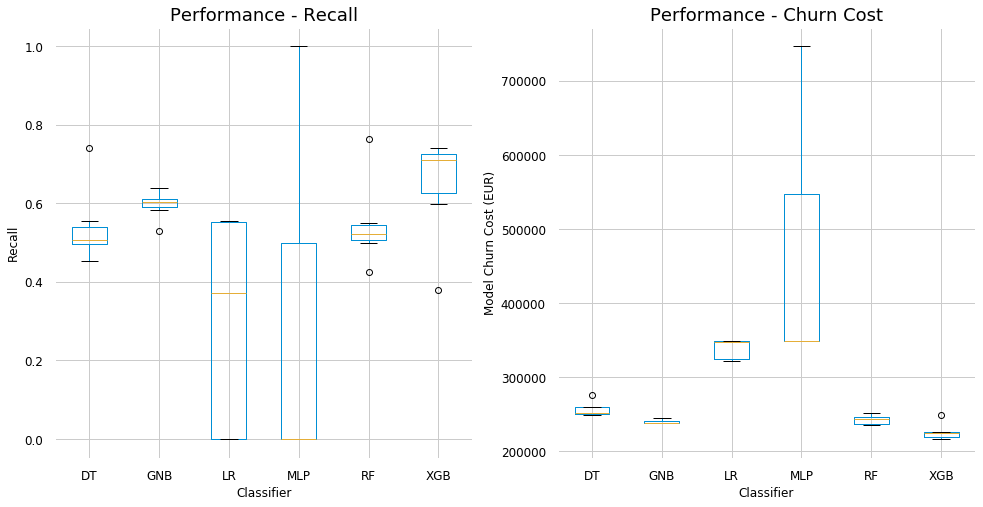

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

exp_metrics.boxplot(column='recall', by='classifier_short', ax=axes[0])

exp_metrics.boxplot(column='model_churn_cost', by='classifier_short', ax=axes[1])

plt.ylabel('Recall')
plt.suptitle(' ')

fig = axes[0].get_figure()
fig.suptitle('', size=20)

axes[0].set_title("Performance - Recall", size=18)
axes[1].set_title("Performance - Churn Cost", size=18)

axes[0].set_ylabel("Recall", fontsize=12)
axes[1].set_ylabel("Model Churn Cost (EUR)", fontsize=12)

axes[0].set_xlabel("Classifier", fontsize=12)
axes[1].set_xlabel("Classifier", fontsize=12)

#fig.tight_layout()

plt.savefig('IMAGES/{}_perf_plots.jpeg'.format(EXP_KEY))

### For this approach plot the best models by classifier

In [ ]:
print("Getting best results by classifier based on {} / ordered ascending? {}".format(measure_by, measure_by_sort))
plot_results = exp_metrics.sort_values(measure_by, ascending=measure_by_sort).groupby('classifier').head(1)
plot_data = filter_top_model_results(plot_results, exp_results)
plot_roc_prc(plot_data, ' ', file_name = 'IMAGES/{}_perf_curves.jpeg'.format(EXP_KEY))

In [ ]:
from scipy import stats
import scikit_posthocs as sp

xgb = plot_data[0][-2]
rf = plot_data[1][-2]
dt = plot_data[2][-2]
gnb = plot_data[3][-2]
lr = plot_data[4][-2]
mlp = plot_data[5][-2]

data = [xgb, rf, dt, gnb, lr, mlp]

stats.kruskal(*data)

In [ ]:
sp.posthoc_conover(data)

In [ ]:
#all_metrics[all_metrics.recall < 1.0].sort_values(['recall'], ascending=[False])

In [ ]:
#all_metrics.sort_values(['recall','precision'], ascending=[False, False])

In [ ]:
print(top_results.to_latex(index=False)) # doctest: +NORMALIZE_WHITESPACE

In [ ]:
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp
import statsmodels.formula.api as sfa

df = sa.datasets.get_rdataset('iris').data
data = [df.loc[ids, 'Sepal.Width'].values for ids in df.groupby('Species').groups.values()]

In [ ]:
H, p = ss.kruskal(*data)
print(H, p)

In [ ]:
sp.posthoc_conover(df, val_col='Sepal.Width', group_col='Species', p_adjust = 'holm')

In [ ]:
df.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width', 'Species']

In [ ]:
lm = sfa.ols('Sepal_Width ~ C(Species)', data=df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

In [ ]:
sp.posthoc_ttest(df, val_col='Sepal_Width', group_col='Species', p_adjust='holm')